Epoch 1/10
63/63 [==============================] - 13s 111ms/step - loss: 1.9489 - accuracy: 0.3282 - val_loss: 2.4658 - val_accuracy: 0.1050
Epoch 2/10
63/63 [==============================] - 5s 85ms/step - loss: 1.3922 - accuracy: 0.5085 - val_loss: 2.9523 - val_accuracy: 0.1020
Epoch 3/10
63/63 [==============================] - 5s 80ms/step - loss: 1.1302 - accuracy: 0.6000 - val_loss: 3.1321 - val_accuracy: 0.1120
Epoch 4/10
63/63 [==============================] - 5s 81ms/step - loss: 0.8975 - accuracy: 0.6862 - val_loss: 3.1664 - val_accuracy: 0.1290
Epoch 5/10
63/63 [==============================] - 5s 82ms/step - loss: 0.6821 - accuracy: 0.7690 - val_loss: 3.2547 - val_accuracy: 0.1890
Epoch 6/10
63/63 [==============================] - 5s 73ms/step - loss: 0.5093 - accuracy: 0.8340 - val_loss: 2.5665 - val_accuracy: 0.2370
Epoch 7/10
63/63 [==============================] - 5s 77ms/step - loss: 0.3433 - accuracy: 0.9005 - val_loss: 2.2646 - val_accuracy: 0.3100
Epoch 8/10


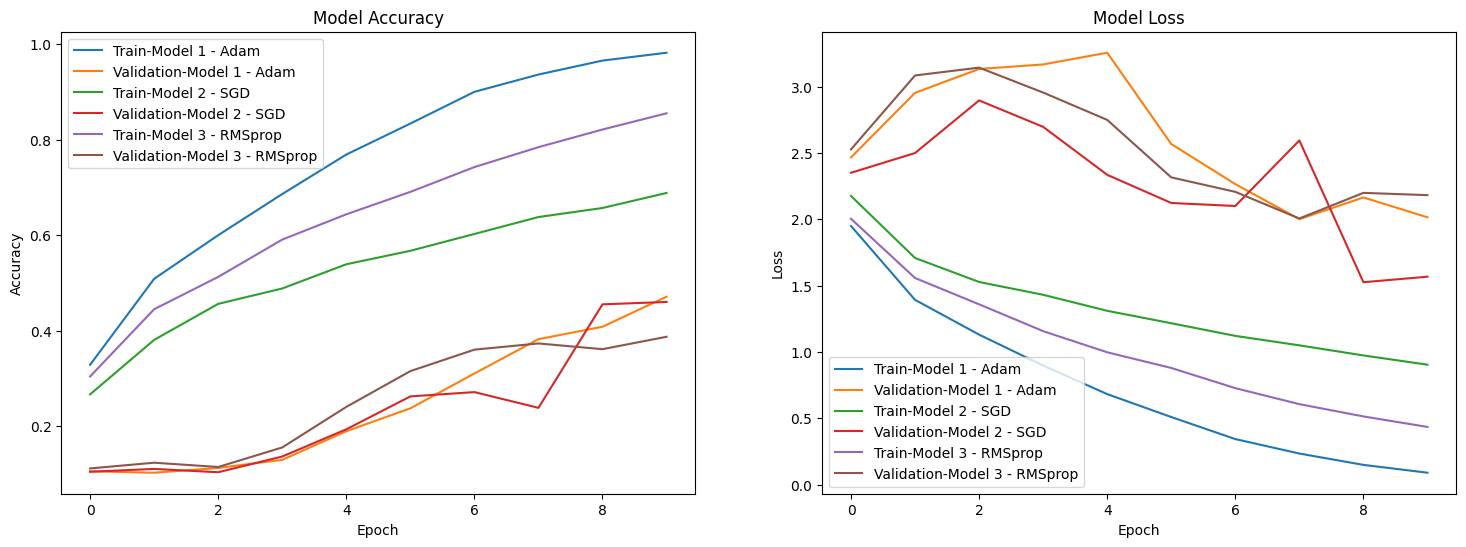

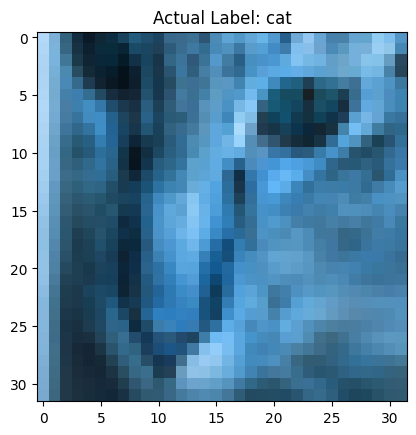

1/1 [==============================] - 0s 200ms/step
Prediction by Model 1 (Adam): cat
Prediction by Model 2 (SGD): frog
Prediction by Model 3 (RMSprop): dog


In [25]:
import numpy as np
import pandas as pd
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Function to load images from folder
def load_images_from_folder(folder, label_data=None, max_images=1000):
    images = []
    labels = []
    count = 0
    for filename in os.listdir(folder):
        if count >= max_images:
            break
        img_id = int(filename.split('.')[0])
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
            if label_data is not None:
                labels.append(label_data[label_data['id'] == img_id]['label'].values[0])
        count += 1
    return np.array(images), np.array(labels)

# Load and preprocess data
train_folder_path = 'train'
test_folder_path = 'test'
train_labels_df = pd.read_csv('trainLabels.csv')
train_images, train_labels = load_images_from_folder(train_folder_path, train_labels_df, max_images=5000)
unique_labels = np.unique(train_labels)
label_to_num = {label: num for num, label in enumerate(unique_labels)}
train_labels = np.array([label_to_num[label] for label in train_labels])
train_images = train_images / 255.0
train_labels = to_categorical(train_labels, num_classes=len(unique_labels))
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create and compile model
def create_compile_model(num_classes, optimizer, dropout_rate=0.0):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Experiments with different optimizers
adam_optimizer = Adam(learning_rate=0.001)
sgd_optimizer = SGD(learning_rate=0.02)
rmsprop_optimizer = RMSprop(learning_rate=0.001)

model1 = create_compile_model(len(unique_labels), adam_optimizer)
history1 = model1.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), batch_size=64)

model2 = create_compile_model(len(unique_labels), sgd_optimizer, dropout_rate=0.2)
history2 = model2.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), batch_size=64)

model3 = create_compile_model(len(unique_labels), rmsprop_optimizer, dropout_rate=0.2)
history3 = model3.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), batch_size=64)

# Plot training history for all models
def plot_history(histories, labels):
    plt.figure(figsize=(18, 6))
    for history, label in zip(histories, labels):
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label=f'Train-{label}')
        plt.plot(history.history['val_accuracy'], label=f'Validation-{label}')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label=f'Train-{label}')
        plt.plot(history.history['val_loss'], label=f'Validation-{label}')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
    plt.show()

# Plot results for all three models
plot_history([history1, history2, history3], ['Model 1 - Adam', 'Model 2 - SGD', 'Model 3 - RMSprop'])

# Create a reverse mapping from numerical labels back to original class names
num_to_label = {num: label for label, num in label_to_num.items()}

# Function to make a prediction using a model
def make_prediction(model, image):
    prediction = model.predict(np.array([image]))
    predicted_class = num_to_label[np.argmax(prediction)]
    return predicted_class

# Select a random image from the test set
random_idx = random.randint(0, len(X_val) - 1)
random_image = X_val[random_idx]
actual_label = num_to_label[np.argmax(Y_val[random_idx])]

# Display the selected image
plt.imshow(random_image)
plt.title(f'Actual Label: {actual_label}')
plt.show()

# Make predictions using each model
pred1 = make_prediction(model1, random_image)
pred2 = make_prediction(model2, random_image)
pred3 = make_prediction(model3, random_image)

# Print out predictions
print(f"Prediction by Model 1 (Adam): {pred1}")
print(f"Prediction by Model 2 (SGD): {pred2}")
print(f"Prediction by Model 3 (RMSprop): {pred3}")
